<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/Assignment3/Assignment3HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<html><h1><center style="color:blue">Human Activity Recognition with Smartphones</center></h1></html>

# Load in Libraries

In [3]:
import matplotlib as mlt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import homogeneity_score, completeness_score, \
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
%matplotlib inline


pd.set_option('display.max_rows', None)

# Read in Files

Upload zip UCI HAR Dataset.zip

In [4]:
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

In [5]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [58]:
# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

# get the data from txt files to pandas dataffame
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = [features]
# add subject column to the dataframe
X_train['subject'] = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None, squeeze=True)

y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'], squeeze=True)
y_train_labels = y_train.map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',\
                       4:'SITTING', 5:'STANDING',6:'LAYING'})

# put all columns in a single dataframe
train = X_train
train['Activity'] = y_train
train['ActivityName'] = y_train_labels

No of Features: 561


In [59]:
print('Shape of the data set: ' + str(train.shape))

Shape of the data set: (7352, 564)


# Data Exploration

### 1. Check for Duplicates

In [60]:
print('No of duplicates in train: {}'.format(sum(train.duplicated()))

/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py:208: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


No of duplicates in train: 0


### 2. Checking for NaN/null values

In [61]:
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))

We have 0 NaN/Null values in train


In [62]:
train.to_csv('train.csv', index=False)
train = pd.read_csv('train.csv')

In [63]:
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


Activity per Subject

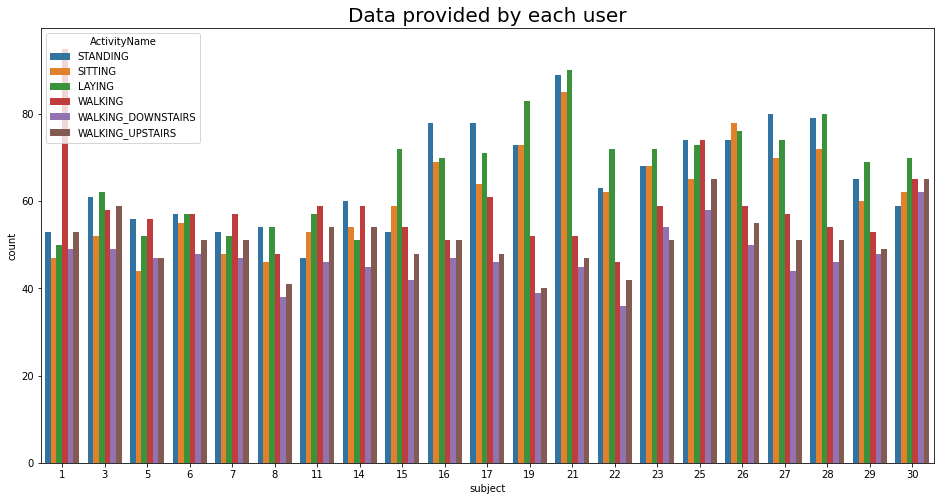

In [64]:
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

Activity Count

Text(0.5, 1.0, 'Count per Activity')

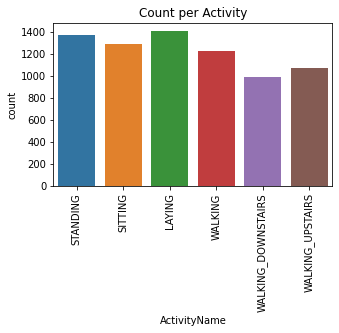

In [65]:
sns.countplot(x ='ActivityName', data = train)
plt.xticks(rotation=90)
plt.title("Count per Activity")

Moving vs Stationary Activities

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

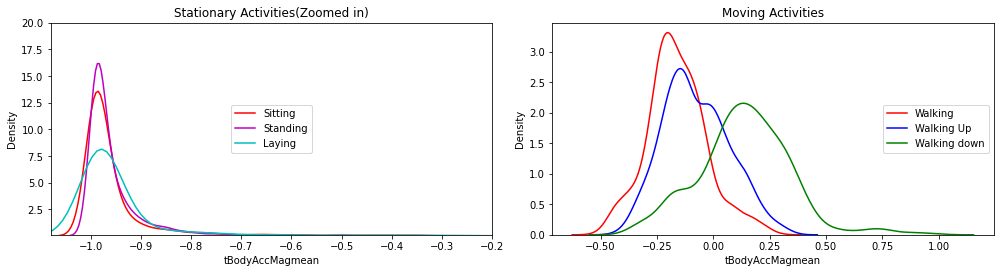

In [66]:
# for plotting purposes taking datapoints of each activity to a different dataframe
df1 = train[train['Activity']==1]
df2 = train[train['Activity']==2]
df3 = train[train['Activity']==3]
df4 = train[train['Activity']==4]
df5 = train[train['Activity']==5]
df6 = train[train['Activity']==6]

plt.figure(figsize=(14,7))
plt.subplot(2,2,1)
plt.title('Stationary Activities(Zoomed in)')
sns.distplot(df4['tBodyAccMagmean'],color = 'r',hist = False, label = 'Sitting')
sns.distplot(df5['tBodyAccMagmean'],color = 'm',hist = False,label = 'Standing')
sns.distplot(df6['tBodyAccMagmean'],color = 'c',hist = False, label = 'Laying')
plt.axis([-1.08, -0.2, 0.1, 20])
plt.legend(loc='center')

plt.subplot(2,2,2)
plt.title('Moving Activities')
sns.distplot(df1['tBodyAccMagmean'],color = 'red',hist = False, label = 'Walking')
sns.distplot(df2['tBodyAccMagmean'],color = 'blue',hist = False,label = 'Walking Up')
sns.distplot(df3['tBodyAccMagmean'],color = 'green',hist = False, label = 'Walking down')
plt.legend(loc='center right')


plt.tight_layout()
plt.show()

# Pre-processing

In [77]:
#save labels as string
X_train = train.drop(['subject', 'Activity','ActivityName'], axis=1)
y_train = train['ActivityName']

In [78]:
X_train.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagenergy,fBodyBodyAccJerkMagiqr,fBodyBodyAccJerkMagentropy,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.999918,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.999867,-0.991134,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.999845,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.

In [79]:
#normalize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# DBSCAN

In [80]:
def getDbscan(eps, min_samples, data_frame, targets):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data_frame)
    dbscan.fit(data_frame)
    # Number of clusters in labels, ignoring noise if present.
    c_labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(c_labels)) - (1 if -1 in c_labels else 0)
    
    df = pd.DataFrame({'clust_label': c_labels, 'orig_label': targets.tolist()})
    ct = pd.crosstab(df['clust_label'], df['orig_label'])
    display(ct)
    print('% 9s' % 'no_clusters  homo    compl   v-meas   ARI     AMI')
    print('%.3f   %.3f   %.3f   %.3f   %.3f   %.3f'
    %(n_clusters_,
    metrics.homogeneity_score(targets, c_labels),
    metrics.completeness_score(targets, c_labels),
    metrics.v_measure_score(targets, c_labels),
    metrics.adjusted_rand_score(targets,c_labels),
     metrics.adjusted_mutual_info_score(targets, c_labels)))

In [81]:
def findDBSCANOptimalEpsilon(features):
  neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
  nbrs=neighb.fit(features) # fitting the data to the object
  distances,indices=nbrs.kneighbors(features) 

  # Sort and plot the distances results
  distances = np.sort(distances, axis = 0) # sorting the distances
  distances = distances[:, 1] # taking the second column of the sorted distances
  plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
  plt.plot(distances) # plotting the distances
  plt.title("Finding value for epsilon")
  plt.show() 

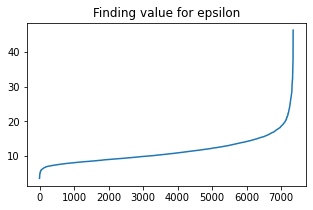

In [82]:
findDBSCANOptimalEpsilon(X_train)

In [83]:
getDbscan(20, 5, X_train, y_train)

orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
-1,37,7,1,46,177,27
0,1370,1279,1373,1180,805,1046
1,0,0,0,0,4,0


no_clusters  homo    compl   v-meas   ARI     AMI
2.000   0.018   0.187   0.033   0.006   0.032


# PCA

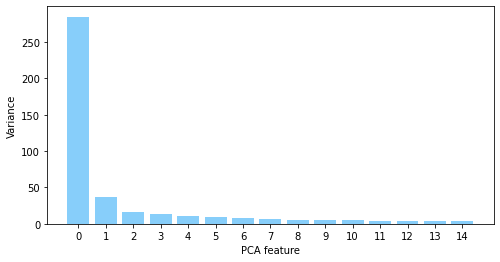

In [84]:
#check for optimal number of features
pca = PCA(random_state=123)
pca.fit(X_train)
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

In [85]:
def pca_transform(n_comp,data):
    pca = PCA(n_components=n_comp, random_state=123)
    dataReduced = pca.fit_transform(data)
    print('Shape of the new Data df: ' + str(dataReduced.shape))
    return dataReduced

In [87]:
X_train_pca = pca_transform(n_comp=1, data=X_train)
getDbscan(1000, 1, X_train_pca, y_train)

Shape of the new Data df: (7352, 1)


orig_label,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
clust_label,,,,,,
0,1407,1286,1374,1226,986,1073


no_clusters  homo    compl   v-meas   ARI     AMI
1.000   0.000   1.000   0.000   0.000   0.000
